In [27]:
import numpy as np
import jax.numpy as jnp

import matplotlib.pyplot as plt
import rcparams
plt.rcParams.update(rcparams.params)

from ripple.waveforms import IMRPhenomD
from ripple import ms_to_Mc_eta

import fdringdown as rd

In [7]:
# G/c**3 (s/kg)
conversion = 2.477e-36

# Solar mass (kg)
M_sun = 2e30

In [61]:
def time_to_merger(f, Mc):
    return (5/(8*np.pi)**(8/3))*(conversion*Mc)**(-5/3)*f**(-8/3)

def gw_frequency(time_to_merger, Mc):
    return (((8*np.pi)**(8/3)/5)*(conversion*Mc)**(5/3)*time_to_merger)**(-3/8)

In [28]:
# Create the event class
event = rd.GWevent('GW150914')

Loading file H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5
Loading file L-L1_GWOSC_4KHZ_R1-1126257415-4096.hdf5


In [29]:
# Get the event GPS time
gps = event.parameters['GPS']

# Detector frame quantities
z = event.parameters['redshift']
m1, m2 = (1+z)*event.parameters['mass_1_source'], (1+z)*event.parameters['mass_2_source']
D = event.parameters['luminosity_distance']

chi1 = 0.
chi2 = 0.
tc = 0.0 # Time of coalescence in seconds
phic = 0.0 # Time of coalescence
inclination = 0.0 # Inclination Angle

In [43]:
# Get a frequency domain waveform

# The PhenomD waveform model is parameterized with the chirp mass and symmetric mass ratio
Mc, eta = ms_to_Mc_eta(jnp.array([m1, m2]))

# These are the parametrs that go into the waveform generator
# Note that JAX does not give index errors, so if you pass in the
# the wrong array it will behave strangely
theta_ripple = jnp.array([Mc, eta, chi1, chi2, D, tc, phic, inclination])

# Now we need to generate the frequency grid
f_l = 4
f_u = 512
del_f = 0.01
fs = jnp.arange(f_l, f_u, del_f)
f_ref = f_l

# And finally lets generate the waveform!
hp_ripple, hc_ripple = IMRPhenomD.gen_IMRPhenomD_polar(fs, theta_ripple, f_ref)

In [70]:
# Project onto interferometer
for IFO in event.IFO_list:
    if IFO.name == 'H1':
        H1 = IFO
        
h_projected = H1.project(
    {'plus':hp_ripple, 'cross':hc_ripple}, 
    1.95, 
    -1.27, 
    gps, 
    0.82, 
    FD=True
    )

In [34]:
# Estimate PSD from data

filtered_data = {
    IFO_name:event.data[IFO_name]-np.mean(event.data[IFO_name]) for IFO_name in event.IFO_names
    }

# Following https://arxiv.org/abs/1409.7215 we estimate the ASD using 1024
# seconds of off-source data. We use a segment of data centered on the event 
# GPS time, where we exclude 4 seconds of data also centered on the GPS time.

# Get the off-source data
pre_off_source_time, pre_off_source_data = event.get_data_segment(
    event.time,
    filtered_data,
    start_time=gps-2-512,
    segment_length=512*event.fs)

post_off_source_time, post_off_source_data = event.get_data_segment(
    event.time,
    filtered_data,
    start_time=gps+2,
    segment_length=512*event.fs)

off_source_time = np.hstack((pre_off_source_time, post_off_source_time))
off_source_data = {}
for IFO_name in event.IFO_names:
    off_source_data[IFO_name] = np.hstack(
        (pre_off_source_data[IFO_name], post_off_source_data[IFO_name]))

# Estimate the ASD
asd_dict = event.estimate_asd(
    off_source_data, nperseg=4*event.fs, noverlap=0, window=('tukey', 0.2), fs=event.fs)

# Frequencies used in the interpolation
asd_f = asd_dict['H1'].x

In [18]:
# Load GWTC1 PSD for reference
psd_f, psd_H, psd_L = np.loadtxt('GWTC1_GW150914_PSDs.dat').T

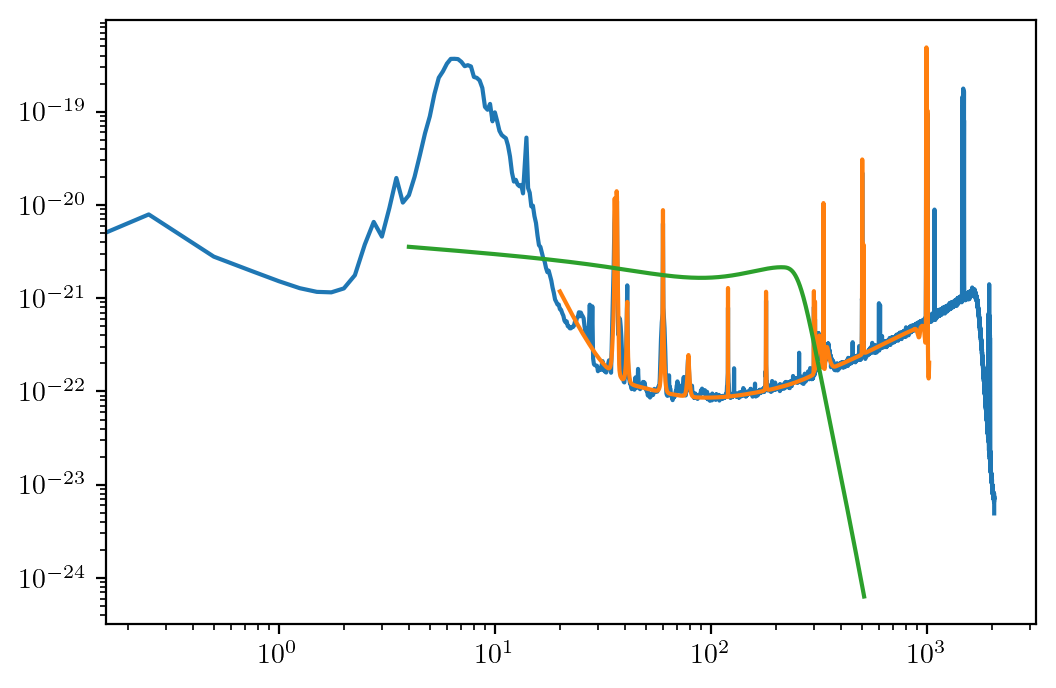

In [71]:
fig, ax = plt.subplots(dpi=200)

ax.plot(asd_f, np.sqrt(asd_f)*asd_dict['H1'](asd_f))
ax.plot(psd_f, np.sqrt(psd_f*psd_H))
ax.plot(fs, 2*fs*abs(h_projected))

ax.set_xscale('log')
ax.set_yscale('log')